tensor(0.5000)


In [91]:
import pandas as pd
import numpy as np

df = pd.read_csv('data/energy_pred/processed.csv')
df

,Power,airTemperature,dewTemperature,windSpeed,month,day,weekday,hour
0,174.0850,1.9,-1.2,5.0,1,1,4,0
1,175.1750,1.6,-1.5,3.0,1,1,4,1
2,175.8725,0.7,-1.8,3.0,1,1,4,2
3,169.0675,0.8,-2.1,4.0,1,1,4,3
4,191.5025,2.9,-1.6,3.0,1,1,4,4
...,...,...,...,...,...,...,...,...
17482,194.0300,4.4,2.4,8.0,12,31,6,19
17483,186.9400,4.0,2.0,8.0,12,31,6,20
17484,181.7150,4.4,1.6,11.0,12,31,6,21
17485,176.6925,4.2,1.2,12.0,12,31,6,22


In [92]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

seq_len, pre_len = 48, 2
X, y, My_X = [], [], []
for i in range(0, len(df) - seq_len - pre_len + 1):
    X.append(df.iloc[i:i+seq_len, 1:].values.flatten())  # 将输入数据展平
    My_X.append(df.iloc[i:i+seq_len].values)  # 保留原始形状
    y.append(df.iloc[i+seq_len:i+seq_len+pre_len, 0].values)
X, y, My_X = np.array(X), np.array(y), np.array(My_X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
MX_train, MX_test, My_train, My_test = train_test_split(My_X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
my_scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
MX_train = my_scaler.fit_transform(MX_train.reshape(-1, MX_train.shape[-1])).reshape(MX_train.shape[0], -1)
MX_test = my_scaler.transform(MX_test.reshape(-1, MX_test.shape[-1])).reshape(MX_test.shape[0], -1)


MSE: 594.8901484346463
R2: 0.9037987097885465
MSE: 246.47224158520294
R2: 0.9601529532395703


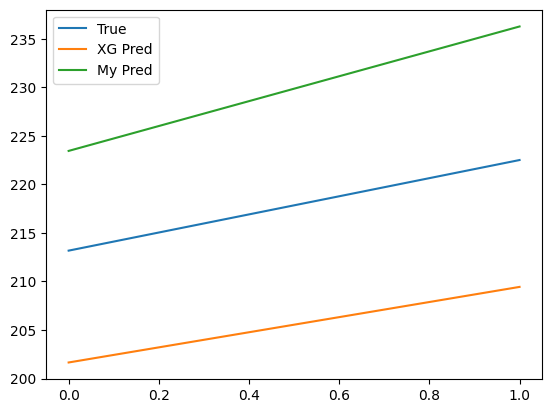

In [93]:
import xgboost as xgb
from model.TCN import TemporalConvNet

from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import torch
import os

# 定义 XGBoost 模型并设置超参数
xgboost = xgb.XGBRegressor(objective='reg:squarederror')

# 训练模型
xgboost.fit(X_train, y_train)

# 在测试集上进行预测
xgboost_pred = xgboost.predict(X_test)
# 加载模型
my_model = TemporalConvNet(seq_len=seq_len, pred_len=pre_len, num_inputs=df.shape[-1], 
                      num_outputs=df.shape[-1], num_channels=[48], kernel_size=df.shape[-1])

my_model.load_state_dict(torch.load(os.path.join('./checkpoints', 'seq2seq_LSTM.pth')))
my_model.eval()

with torch.no_grad():
    MX_test_tensor = torch.tensor(MX_test.reshape(MX_test.shape[0], -1, df.shape[-1])).float()
    
    my_pred = my_model(MX_test_tensor, pre_len, pre_len, pre_len)
    my_pred = (my_scaler.inverse_transform(my_pred.reshape(-1 ,my_pred.shape[-1]))).reshape(my_pred.shape[0], -1, my_pred.shape[-1])[:,:,0]


# 计算 MSE 和 R2
xg_mse = mean_squared_error(y_test, xgboost_pred)
xg_r2 = r2_score(y_test, xgboost_pred)
print('MSE:', xg_mse)
print('R2:', xg_r2)

my_mse = mean_squared_error(y_test, my_pred)
my_r2 = r2_score(y_test, my_pred)
print('MSE:', my_mse)
print('R2:', my_r2)

# 使用 matplotlib 绘制真实值和预测值的图像
plt.plot(y_test[10, :], label='True')
plt.plot(xgboost_pred[10, :], label='XG Pred')
plt.plot(my_pred[10, :], label='My Pred')
plt.legend()
plt.show()

